# VGG16  Lite Version Implementation with Old LC 

In [1]:
import glob
import sys
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
from src.models.VGG16 import VGG16
import src.compression.deltaCompress as lc_compress
from src.models.VGG16_LowRank import getBase, VGG16_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, lazy_restore, evaluate_compression
import torchvision

c:\Users\Bradf\anaconda3\envs\py310\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Definition of Data Loader function

In [2]:
HDFP = "./volumes/Ultra Touch" # Load HHD

def data_loader():
    # transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(32, antialias=True)])
    transform = transforms.Compose([
    transforms.Resize(32, antialias=True),  # ou (32, 32), redimensionne les images à 32x32
    transforms.ToTensor(),  # Convertit les images PIL ou numpy.ndarray en Tensors.
    # transforms.Normalize((0.1307,), (0.3081,))  # Normalise les données
    ])

    trainset = datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    # Reintroduce the 2000 datapoints model has not seen before.
    trainset.data = trainset.data.clone()[-2000:-1000]
    trainset.targets = trainset.targets.clone()[-2000:-1000]
    # trainset.data = trainset.data.clone()[:58000]
    # trainset.targets = trainset.targets.clone()[:58000]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32,
                                              shuffle=False, num_workers=2)

    testset = datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    # testset.data = testset.data[:2000]
    # testset.targets = testset.targets[:2000]
    testset.data = testset.data[:300]
    testset.targets = testset.targets[:300]
    testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
                                             shuffle=False, num_workers=2)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
                                             shuffle=False, num_workers=2)
    
    return trainloader, testloader

## Calling MNIST dataset

In [3]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

## Bypass the matplotlib error

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Showing some images of the dataset we use

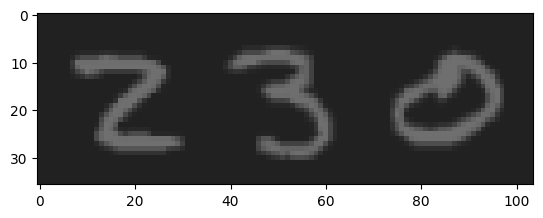

tensor(2) tensor(3) tensor(0)


In [5]:
# Adjust these values to match the normalization values used during the loading of your dataset
mean = 0.1307
std = 0.3081

# Function to show an image
def imshow(img):
    # Adjusting unnormalization for potentially 3-channel images
    img = img * std + mean  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Assuming train_loader is defined and loaded as before
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:3]))
# Print labels
print(' '.join('%5s' % labels[j] for j in range(3)))


## Creation of folder to save the results (for plots and compression rate)

In [6]:
SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

## Definition of the accuracy functions

In [7]:
def accuracy_binary(model, evaluation_set):
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for input, label in evaluation_set:  # Iterate over the evaluation dataset.
            output = torch.sigmoid(model(input))  # Apply sigmoid to model output to get probabilities.
            output = torch.where(output > 0.5, 1, 0)  # Threshold probabilities at 0.5 to decide between classes 0 and 1.
            no_seen += label.size(0)  # Count the number of samples seen (batch size).
            no_correct += (output == label).sum().item()  # Increment correct predictions by the number of matches in the batch.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.

def accuracy_multiclass(model, evaluation_set):
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for input, label in evaluation_set:  # Iterate over the evaluation dataset.
            output = model(input)  # Get the raw logits from the model.
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max logit which represents the predicted class.
            no_seen += label.size(0)  # Count the number of samples seen (batch size).
            no_correct += pred.eq(label.view_as(pred)).sum().item()  # Compare predictions with true labels and sum up correct predictions.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.


## Special function for the accuracy of the model on GPU 

In [8]:
def accuracy_multiclass_gpu(model, evaluation_set):
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for inputs, labels in evaluation_set:  # Iterate over the evaluation dataset.
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device of the model
            output = model(inputs)  # Get the raw logits from the model.
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max logit which represents the predicted class.
            no_seen += labels.size(0)  # Count the number of samples seen (batch size).
            no_correct += pred.eq(labels.view_as(pred)).sum().item()  # Compare predictions with true labels and sum up correct predictions.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.


## On GPU (Testing if it works with loss)

In [ ]:
# get the base model (VGG16)

model_for_checkpoint = VGG16()


# train model_for_checkpoint such that we compute the loss for the validation dataset and the training dataset (just for the sake of it), et take the checkpoint at the minimum validation loss

# define the loss function

criterion = nn.CrossEntropyLoss()

# define the optimizer

optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.1)

# define the number of epochs

n_epochs = 10

# define the validation loss

valid_loss_min = np.Inf

# GPU check with print

if torch.cuda.is_available():
    print("GPU available")

else:
    print("GPU not available")

    
# move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# move the model to the GPU

model_for_checkpoint.to(device)

# train the model

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    model_for_checkpoint.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model_for_checkpoint(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)

    model_for_checkpoint.eval()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model_for_checkpoint(data)

        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
        # torch.save(model_for_checkpoint.state_dict(), 'model_for_checkpoint.pt')
        valid_loss_min = valid_loss

## On CPU (Testing if it works with loss)

In [ ]:
# # get the base model (VGG16)

# model_for_checkpoint = VGG16()


# # train model_for_checkpoint such that we compute the loss for the validation dataset and the training dataset (just for the sake of it), et take the checkpoint at the minimum validation loss

# # define the loss function

# criterion = nn.CrossEntropyLoss()

# # define the optimizer

# optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.1)

# # define the number of epochs

# n_epochs = 10

# # define the validation loss

# valid_loss_min = np.Inf

# # GPU check with print

# if torch.cuda.is_available():
#     print("GPU available")

# else:
#     print("GPU not available")

    
# # move the model to the GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # move the model to the GPU

# model_for_checkpoint.to(device)

# # train the model

# for epoch in range(1, n_epochs+1):
#     train_loss = 0.0
#     valid_loss = 0.0

#     model_for_checkpoint.train()

#     for data, target in train_loader:
#         data, target = data.to(device), target.to(device)

#         optimizer.zero_grad()

#         output = model_for_checkpoint(data)

#         loss = criterion(output, target)

#         loss.backward()

#         optimizer.step()

#         train_loss += loss.item()*data.size(0)

#     model_for_checkpoint.eval()

#     for data, target in test_loader:
#         data, target = data.to(device), target.to(device)

#         output = model_for_checkpoint(data)

#         loss = criterion(output, target)

#         valid_loss += loss.item()*data.size(0)

#     train_loss = train_loss/len(train_loader.sampler)
#     valid_loss = valid_loss/len(test_loader.sampler)

#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
#         # torch.save(model_for_checkpoint.state_dict(), 'model_for_checkpoint.pt')
#         valid_loss_min = valid_loss

## Usual training on GPU (Creating branchpoints)

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# get the base model (VGG16NoLite) and move it to the chosen device
model_for_checkpoint = VGG16().to(device)

# creating branchpoints
epochs = 10
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.1) 
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    for iter, data in enumerate(train_loader):
        # data, target = data.to(device), target.to(device)

        # optimizer.zero_grad()

        # output = model_for_checkpoint(data)

        # loss = criterion(output, target)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

        optimizer.zero_grad()
        outputs = model_for_checkpoint(inputs)

        # Here assuming your loss function and any other operation are compatible with CUDA tensors
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)

        loss.backward()
        optimizer.step()



        if iter % 20 == 0:
            # print("Running validation for {} Epoch, {} Iteration...".format(epoch, iter))
            res = accuracy_multiclass_gpu(model_for_checkpoint, test_loader)  # Ensure this function also handles data on GPU

            # print("ACCURACY: {}".format(res))
            if res > 0.7:
                # Move model to CPU before saving
                model_for_checkpoint.to('cpu')
                torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vgg16lite/branch_{}.pt".format(res))
                # Optionally, move model back to the original device (GPU) if further computation is needed
                model_for_checkpoint.to(device)
                print("Model saved at accuracy: ", res)

            if res > 0.9:
                isLoop = False
                print("Model saved at accuracy: ", res)
                break
        
    print("Epoch : [{}/{}], Training Loss: {}".format(epoch, epochs, loss.item()))
    if not isLoop:
        break
    print("Length of train_loader is: ", len(train_loader))


## Usual training on CPU (Creating branchpoints)

In [ ]:
# get the base model (VGG16)

model_for_checkpoint = VGG16()

# creating branchpoints : 

epochs = 10
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.1) # momentum=0.9

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch, epochs))
    for iter, data in enumerate(train_loader):
        inputs, labels = data
        # print(inputs, labels)
        optimizer.zero_grad()
        outputs = model_for_checkpoint(inputs)

        # if self.config.loss_function == "binary_cross_entropy":
        #     outputs = torch.sigmoid(outputs)
        
        # loss = loss_function(outputs, labels)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        # print("Epoch {} | Iteration {} : Loss {}".format(epoch, iter, loss.item()))
        if iter % 20 == 0:
            # print("Running validation for {} Epoch, {} Iteration...".format(epoch, iter))
            # Previously: res = accuracy_binary(model_for_checkpoint, test_loader)
            res = accuracy_multiclass(model_for_checkpoint, test_loader)

            # res = accuracy_binary(model_for_checkpoint, test_loader)
            
            print("ACCURACY: {}".format(res))
            if res > 0.7:
                torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vgg/branch_{}.pt".format(res))
                print("Model saved at accuracy: ", res)
            if res > 0.9:
                isLoop = False
                print("Model saved at accuracy: ", res)
                break

    print("Epoch : [{}/{}], Training Loss: {}".format(epoch, epochs, loss.item()))

    if not isLoop:
        break
    print("Length of train_loader is: ", len(train_loader))

## Exploiting branchpoints of the model

### Call of the different models to compare

In [9]:
DECOMPOSED_LAYERS = ['classifier.0.weight', 'classifier.3.weight', 'classifier.6.weight']
RANK = -1
SCALING = -1
BRANCH_ACC = "0.815"

# Set up weights for original AlexNet model
original = VGG16()
model_original = VGG16()

# Load from "branch point"
BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/vgg16lite/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))
print(model_original.state_dict().keys())
w, b = getBase(model_original)
model = VGG16_LowRank(w, b, rank = RANK)


odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.2.weight', 'feature.2.bias', 'feature.5.weight', 'feature.5.bias', 'feature.7.weight', 'feature.7.bias', 'feature.10.weight', 'feature.10.bias', 'feature.12.weight', 'feature.12.bias', 'feature.15.weight', 'feature.15.bias', 'feature.17.weight', 'feature.17.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


### Verification of the bias shape

In [10]:
for bias in b:
    print(bias.shape)

torch.Size([4096])
torch.Size([4096])
torch.Size([10])


### Loading and updating model state dictionary from Checkpoint

In [11]:
new_sd = model.state_dict()
for k, v in torch.load(BRANCH_LOC).items():

    # print(k)
    if k not in DECOMPOSED_LAYERS:
        new_sd[k] = v

print(new_sd)

model.load_state_dict(new_sd)

OrderedDict([('feature.0.weight', tensor([[[[-2.7171e-02, -2.0163e-01, -3.8350e-03],
          [-2.3919e-01,  3.3133e-01, -9.7691e-02],
          [-4.1274e-02,  2.3016e-01, -2.8128e-01]]],


        [[[-2.6776e-01, -4.0983e-02,  3.3424e-01],
          [ 2.5786e-01,  1.8453e-01,  3.4241e-01],
          [-3.6565e-01, -2.6042e-02, -1.0944e-01]]],


        [[[ 1.7511e-01,  2.8021e-01, -2.3105e-01],
          [-1.3877e-01, -2.2253e-01,  2.7481e-01],
          [-2.2040e-01,  1.5039e-01,  9.2376e-02]]],


        [[[ 9.8391e-03,  2.3033e-01,  3.0059e-01],
          [-2.4200e-01, -2.4981e-02,  2.3942e-01],
          [ 9.7838e-02, -3.2190e-02,  1.4032e-01]]],


        [[[-7.3022e-02, -2.6168e-04,  2.1118e-02],
          [-1.7005e-02,  1.0311e-01, -9.5051e-03],
          [ 1.0789e-01,  1.3404e-01, -2.7348e-02]]],


        [[[ 2.1918e-01,  9.6900e-02,  1.4084e-01],
          [ 3.1019e-01, -3.4097e-01, -7.4522e-02],
          [-6.0743e-02, -1.9443e-01,  4.7198e-02]]],


        [[[ 3.6003e-02, 

<All keys matched successfully>

### Loading checkpoint, optimizer setup, and layer filtering

In [12]:

load_sd_decomp(torch.load(BRANCH_LOC), model, DECOMPOSED_LAYERS)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer_full = torch.optim.SGD(model_original.parameters(), lr = learning_rate)

In [15]:
# delta_normal_max = []
# delta_normal_min = []
# delta_decomposed_max = []
# delta_decomposed_min = []

full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []

current_iter = 0
current_set = 0

current_iter_old_lc = 0
current_set_old_lc = 0

acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)

for epch in range(20):
    for i, data in enumerate(train_loader, 0):
        print("Epoch: {}, Iteration: {}".format(epch, i))
        
        set_path = "/set_{}".format(current_set)
        if not os.path.exists(SAVE_LOC + set_path):
            os.makedirs(SAVE_LOC + set_path)

        if i == 0 and epch == 0: # first iteration, create baseline model
            base, base_decomp = lc.extract_weights(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)
        else:
            if i % 10 == 0: 
                # full snapshot!
                new_model = lazy_restore(base, base_decomp, bias, VGG16(), 
                                          original.state_dict(), DECOMPOSED_LAYERS, rank = RANK, scaling = SCALING)
                original = new_model # Changing previous "original model" used to restore the loRA model.
                
                current_set += 1
                current_iter = 0

                set_path = "/set_{}".format(current_set)
                if not os.path.exists(SAVE_LOC + set_path):
                    os.makedirs(SAVE_LOC + set_path)
                
                # Rebuilding LoRA layers => reset model!
                w, b = getBase(original)
                model = VGG16_LowRank(w, b, rank = RANK)
                optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
                load_sd_decomp(original.state_dict(), model, DECOMPOSED_LAYERS)
                base, base_decomp = lc.extract_weights(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)

            else:
                # Delta-compression
                delta, decomp_delta, bias = lc.generate_delta(base, 
                                                                base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                            decomp_delta)
                
                # Saving checkpoint
                lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                                "/set_{}".format(current_set))
    
                base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                base_decomp = np.add(full_dcomp_delta, base_decomp)

                current_iter += 1
            
        # # ==========================
        # # Saving using LC-Checkpoint
        # # ==========================
                
        if i == 0 and epch == 0:
            cstate = model_original.state_dict()
            set_path = "/set_{}".format(current_set_old_lc)
            if not os.path.exists(SAVE_LOC_OLC + set_path):
                os.makedirs(SAVE_LOC_OLC + set_path)
            # torch.save(cstate, SAVE_LOC_OLC + set_path + "/initial_model.pt")
            prev_state = olc.extract_weights(cstate, SAVE_LOC_OLC + set_path)
        else:
            if i % 10 == 0:
                cstate = model_original.state_dict()
                current_set_old_lc += 1
                current_iter_old_lc = 0
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                # torch.save(cstate, SAVE_LOC_OLC + set_path + "/initial_model.pt")
                prev_state = olc.extract_weights(cstate, SAVE_LOC_OLC + set_path)
            else:
                cstate = model_original.state_dict()
                old_lc_delta, old_lc_bias = olc.generate_delta(prev_state, cstate, DECOMPOSED_LAYERS)
                olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                                    old_lc_bias, current_iter_old_lc)
                prev_state = np.add(prev_state, update_prev)
                current_iter_old_lc += 1
        
        # ==========================
        # Training on Low-Rank Model
        # ==========================

        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs,labels)
        loss.backward()
        optimizer.step()
            
        # ======================
        # Training on Full Model
        # ======================

        # Zero the parameter gradients
        optimizer_full.zero_grad()

        # Forward + backward + optimize
        outputs_full = model_original(inputs)
        loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
        loss_full.backward()
        optimizer_full.step()

        if i % 20 == 0:
            print("Training Accuracy | Decomposed: {}, Full : {}".format(acc(outputs, labels), 
                                                                         acc(outputs_full, labels)))

        if i != 0  and i % 5 == 0: # Evaluation on testing set
            full_accuracy.append(evaluate_accuracy(model_original, test_loader))
            decomposed_full_accuracy.append(evaluate_accuracy(model, test_loader))
            restored_model = lazy_restore(base, base_decomp, bias, VGG16(), 
                                          original.state_dict(), DECOMPOSED_LAYERS, 
                                          rank = RANK, scaling = SCALING)
            restored_accuracy.append(evaluate_accuracy(restored_model, test_loader))
            restored_lc_model = VGG16()
            restored_lc_model.load_state_dict(olc.restore_state_dict(prev_state, old_lc_bias, 
                                                                  restored_model.state_dict(), DECOMPOSED_LAYERS))
            lc_accuracy.append(evaluate_accuracy(restored_lc_model, test_loader))
            print("Full accuracy: {}, LC accuracy: {}, Decomposed-Full accuracy: {}, Decomposed-Restored accuracy: {}".format(
                full_accuracy[-1], lc_accuracy[-1], decomposed_full_accuracy[-1], restored_accuracy[-1]))

Epoch: 0, Iteration: 0
saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/lobranch/set_0\base_model.pt
old_lc | saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/old-lc/set_0/initial_model.pt
Training Accuracy | Decomposed: 0.9375, Full : 0.9375
Epoch: 0, Iteration: 1
Saving Checkpoint: lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/lobranch/set_0
Saving Checkpoint: old_lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/old-lc/set_0
Epoch: 0, Iteration: 2
Saving Checkpoint: lc_checkpoint_1.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/lobranch/set_0
Saving Checkpoint: old_lc_checkpoint_1.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/old-lc/set_0
Epoch: 0, Iteration: 3
Saving Checkpoint: lc_checkpoint_2.pt @ ./volumes/

In [ ]:
import json

with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg/data.json") as f:
    data = json.load(f)
full_accuracy = data['full_acc']
lc_accuracy = data["lc_restored_accuracy"]
restored_accuracy = data["decomposed_restored_accuracy"]
decomposed_full_accuracy = data["decomposed_full_accuracy"]

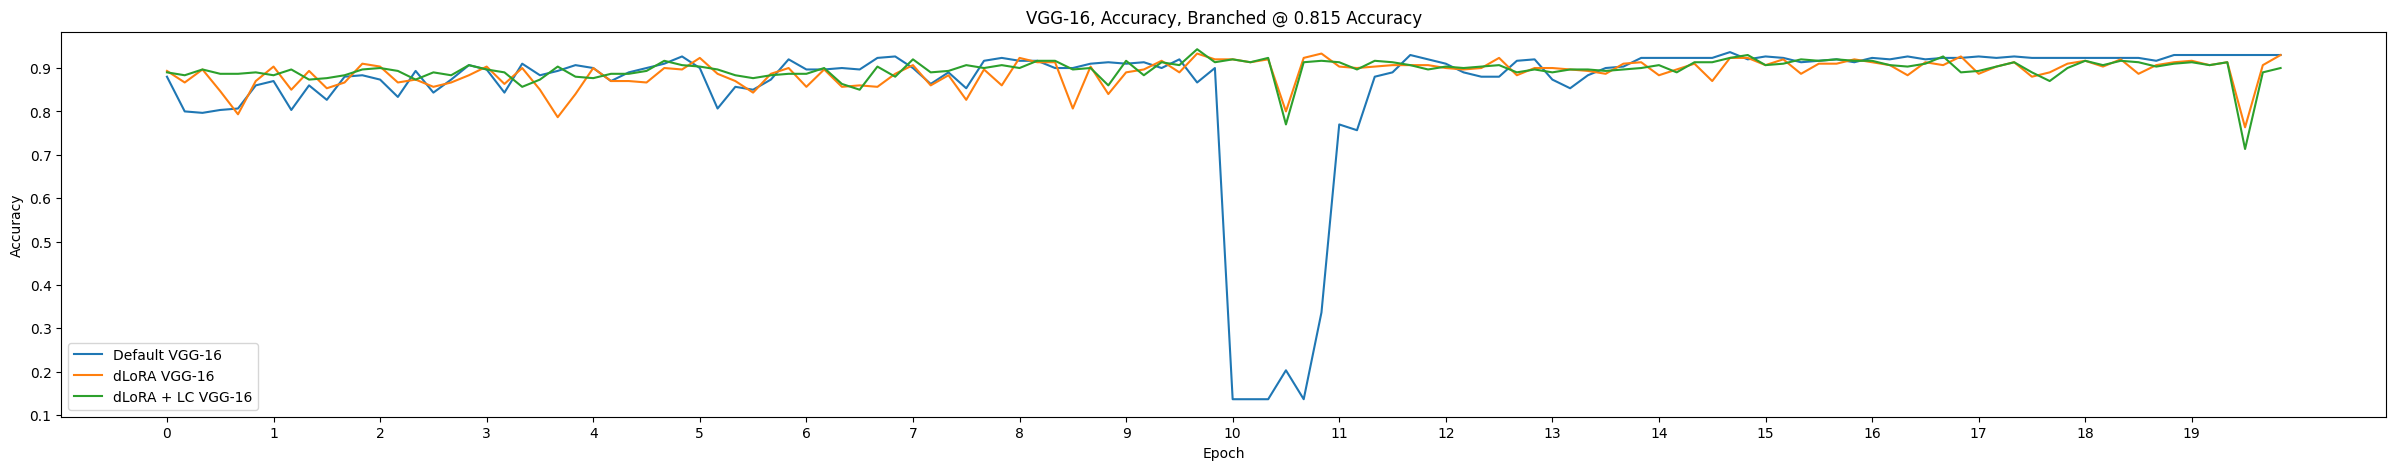

In [16]:
plt.figure(figsize = (30, 5))
plt.title("VGG-16, Accuracy, Branched @ {} Accuracy".format(BRANCH_ACC))
plt.plot(full_accuracy, label = "Default VGG-16")
# plt.plot(lc_accuracy, label = "LC VGG-16")
plt.plot(decomposed_full_accuracy, label = "dLoRA VGG-16")
plt.plot(restored_accuracy, label = "dLoRA + LC VGG-16")
plt.xticks([x for x in range(0, 120) if x % 6 == 0], [x for x in range(0, 20)])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

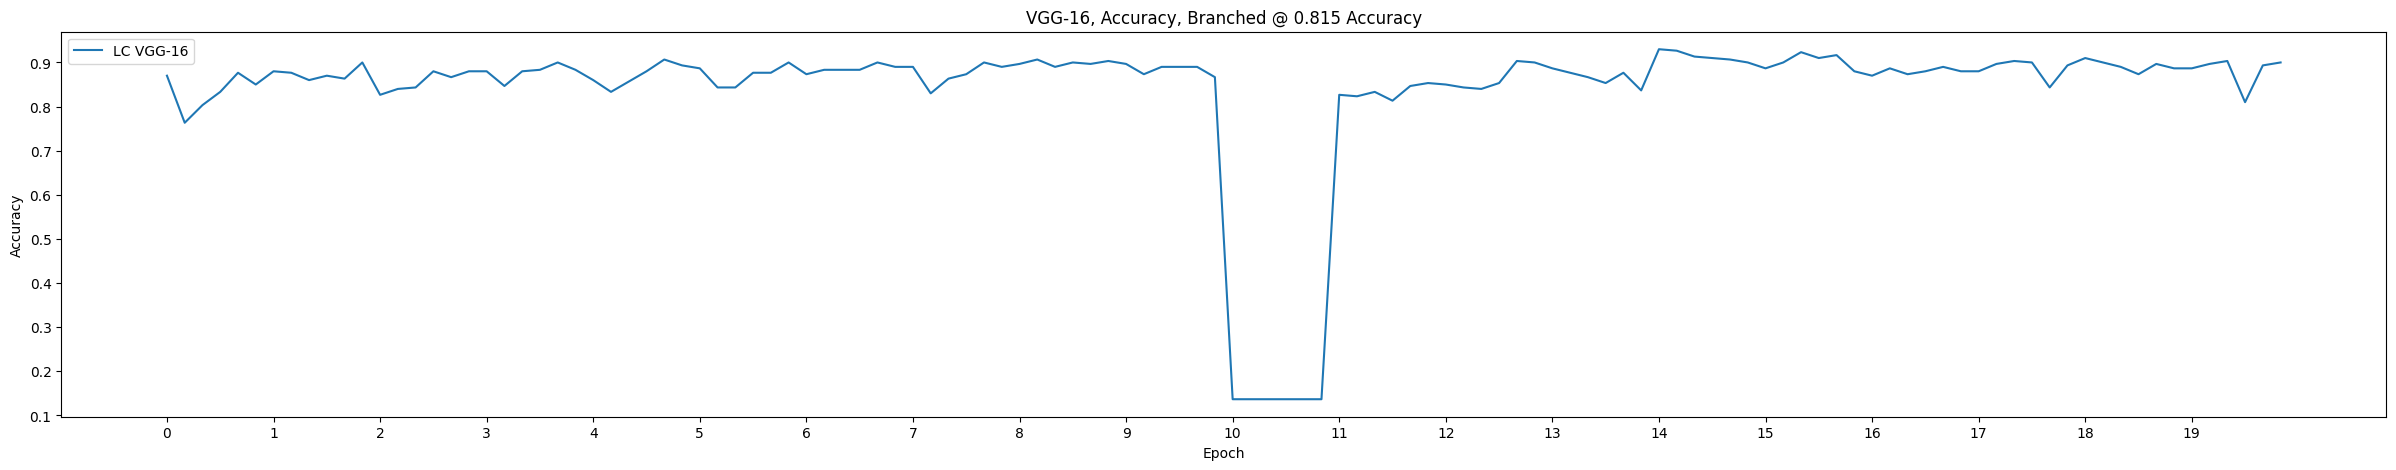

In [17]:
plt.figure(figsize = (30, 5))
plt.title("VGG-16, Accuracy, Branched @ {} Accuracy".format(BRANCH_ACC))
plt.plot(lc_accuracy, label = "LC VGG-16")
plt.xticks([x for x in range(0, 120) if x % 6 == 0], [x for x in range(0, 20)])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

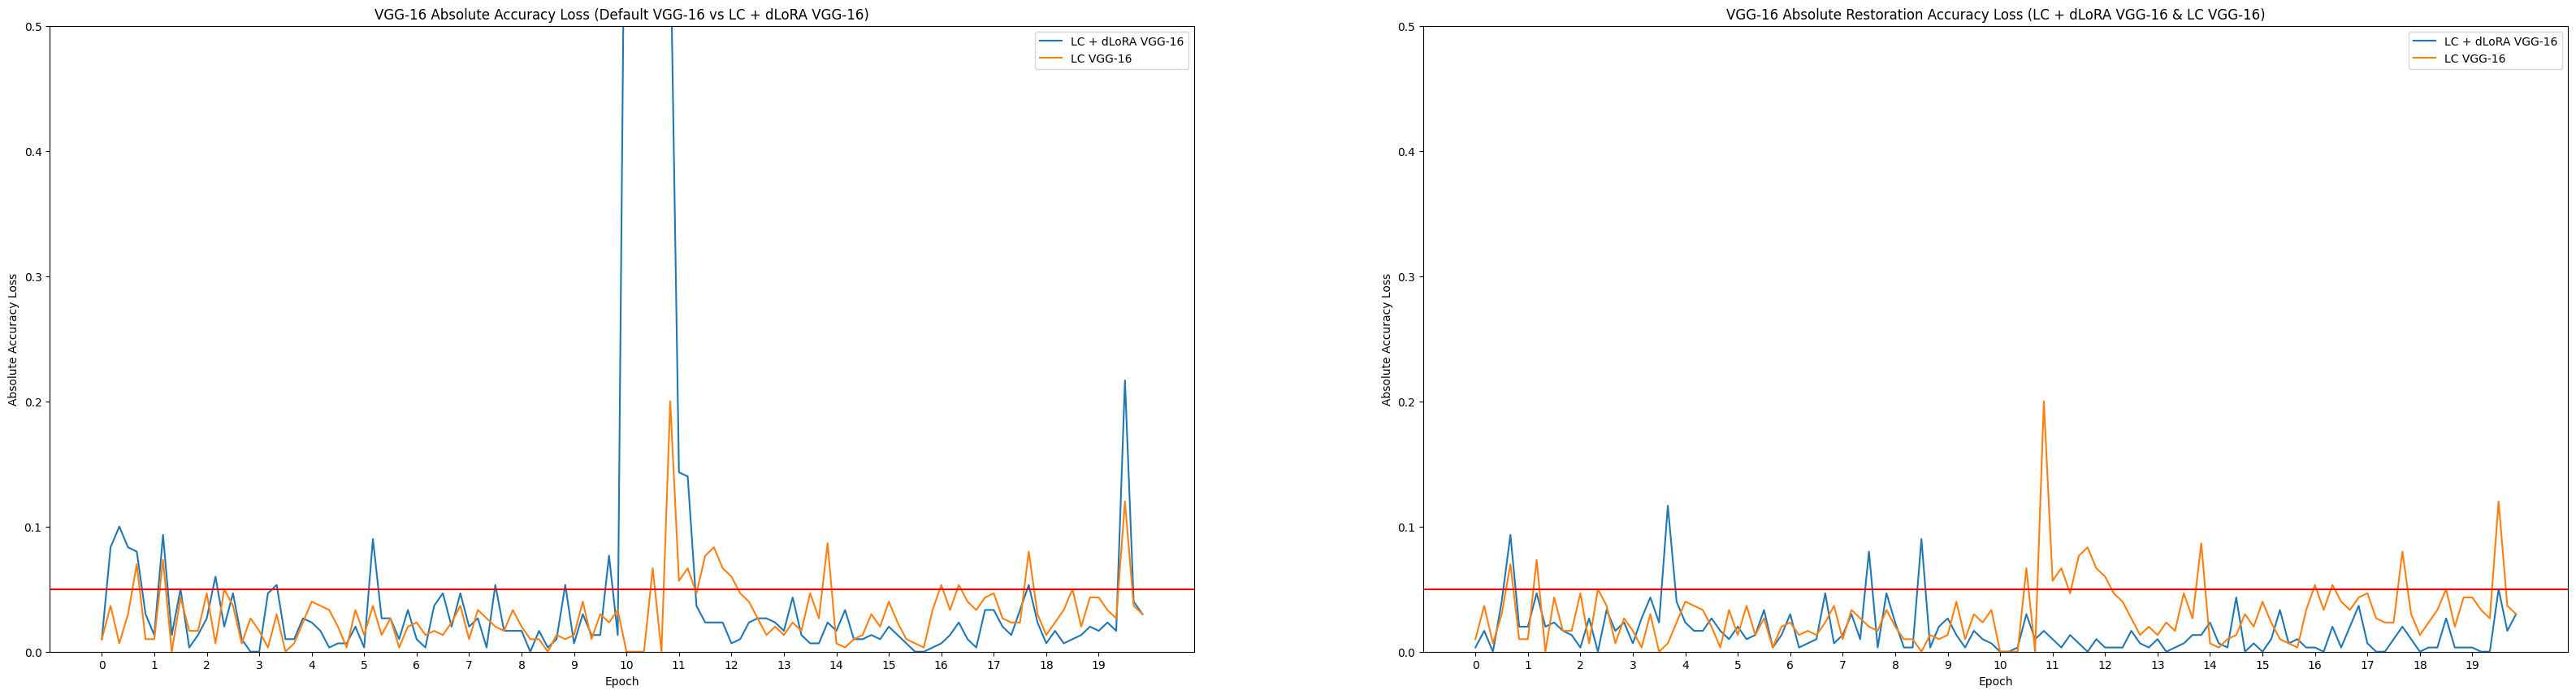

In [18]:
rangex = [x for x in range(0, 120) if x % 6 == 0]
rangey = [x for x in range(0, 20)]
plt.figure(figsize = (40, 10))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("VGG-16 Absolute Accuracy Loss (Default VGG-16 vs LC + dLoRA VGG-16)")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(restored_accuracy))), label = "LC + dLoRA VGG-16")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC VGG-16")
plt.legend()
plt.xticks(rangex, rangey)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.axhline(y = 0.05, color = 'r')
plt.ylim(0, 0.5)
ax2 = plt.subplot(1, 2, 2)
ax2.set_title("VGG-16 Absolute Restoration Accuracy Loss (LC + dLoRA VGG-16 & LC VGG-16)")
plt.plot(np.abs(np.subtract(np.array(restored_accuracy), 
                     np.array(decomposed_full_accuracy))), label = "LC + dLoRA VGG-16")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC VGG-16")
plt.legend()
plt.axhline(y = 0.05, color = 'r')
plt.xticks(rangex, rangey)
plt.ylim(0, 0.5)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.show()

In [19]:
import math
def getsize(sl):
    dir = [x for x in os.listdir(sl)]
    csize, usize = 0, 0
    for set in dir:
        for f in os.listdir(sl + "/" + set):
            fp = sl + "/{}/{}".format(set, f)
            csize += os.path.getsize(fp)
            usize += 119.6 * math.pow(2, 20) # torch checkpoint same size
    return csize, usize

In [21]:
compressed_size, uncompressed_size = getsize(SAVE_LOC)
a, b = evaluate_compression(uncompressed_size, compressed_size)
compressed_size, uncompressed_size = getsize(SAVE_LOC_OLC)
a1, b1 = evaluate_compression(uncompressed_size, compressed_size)

print("LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a1, b1))
print("LoRA + LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

LC-Checkpoint + GZIP
Compression Ratio: 821.121%, Space Savings: 87.822%
LoRA + LC-Checkpoint + GZIP
Compression Ratio: 4629.354%, Space Savings: 97.84%


In [22]:
import json
data = {
    "full_acc" : full_accuracy,
    "decomposed_restored_accuracy" : restored_accuracy,
    "decomposed_full_accuracy" : decomposed_full_accuracy,
    "lc_restored_accuracy" : lc_accuracy
}
with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vgg16lite/data.json", 'w') as f:
    json.dump(data, f)